In [1]:
import sys
import os

import time
import glob 
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

from torchvision import transforms
from torchvision.io import read_image

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None, target_transform=None):

        self.img_labels = []
        self.img_paths = []
        self.transform = transform
        self.target_transform = target_transform

        # Map class names to numerical labels
        self.classes = [
            'Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
            'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
            'Scentless Mayweed', 'Shepherds Purse', 
            'Small-flowered Cranesbill', 'Sugar beet'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Traverse folder structure
        for class_name in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):
                label = self.class_to_idx[class_name]
                for img_file in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_file)
                    if img_path.endswith(('.png', '.jpg', '.jpeg')):  # Filter valid image files
                        self.img_paths.append(img_path)
                        self.img_labels.append(label)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        label = self.img_labels[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
    

class MinMaxScaler:
    def __init__(self, min_value=0.0, max_value=1.0):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, tensor):
        min_val = tensor.min()
        max_val = tensor.max()
        return (tensor - min_val) / (max_val - min_val + 1e-7) * (self.max_value - self.min_value) + self.min_value
    

transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),
    MinMaxScaler(min_value=0.0, max_value=1.0) 
])

In [3]:
train_folder = './Data/train'
val_folder = './Data/validation'
test_folder = './Data/test'

train_dataset = CustomImageDataset(train_folder, transform=transform)
test_dataset = CustomImageDataset(test_folder, transform=transform)
val_dataset = CustomImageDataset(val_folder, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)    
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)    

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
learning_rate = 0.00001
batch_size = 64
epochs = 5

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.layer  = nn.Sequential(
            # kernel1
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            # kernel1_1 # add7(1)
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            # pool
            nn.MaxPool2d(kernel_size=2,stride=2),        
            
            # kernel2
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),

            # kernel2_1 # add7(2)
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),        

            # kernel3_1
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),

            # kernel3_2
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            
            # kernel3_3
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),    

            # kernel3_4 #add3_ver(3)
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),  

            # kernel3_5 #add3_ver(4)
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2,stride=2),

            # kernel4_1
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),

            # kernel4_2
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),

            # kernel4_3 #add3_ver(5)
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),

            # kernel4_4 # add7(6)
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            # kernel5_1
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),    

            # kernel5_2
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),    

            # kernel5_3 #add3_ver(6)
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),    
            nn.MaxPool2d(kernel_size=2,stride=2),
    )

        self.fc_layer = nn.Sequential(
            nn.Linear(2 * 2 * 512, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 12),
        )

    def forward(self,x):
    	# self.layer에 정의한 연산 수행
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        # self.fc_layer 정의한 연산 수행    
        out = self.fc_layer(out)
        return out

In [6]:
# Define the model
model = NeuralNetwork().to(device)
print(model)

# 손실 함수를 초기화
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NeuralNetwork(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): ReLU()
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (17): ReLU()
    (18): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        test_loss, correct = 0, 0

        # 역전파
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        correct /= size
        if batch % 64 == 0:
            loss = loss.item()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss = loss_fn(pred, y)
            print(f"train loss: {loss:.03f} train accuracy {correct:>5d}/{size:>5d}]")

    return loss


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for batch, (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):0.2f}, Avg loss: {test_loss:>8f} \n")

def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):0.2f}, Avg loss: {test_loss:>8f} \n")

In [8]:
# Hyperparameters
learning_rate = 0.00001
batch_size = 64
n_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
loss_train_history = []
acc_train_history = []
loss_val_history = []
acc_val_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(n_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    for X_train_batch, Y_train_batch in train_dataloader:
        X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_train_batch)
        loss = criterion(outputs, Y_train_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == Y_train_batch).sum().item()

    train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = total_train_correct / len(train_dataset)
    loss_train_history.append(train_loss)
    acc_train_history.append(train_accuracy)

    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    with torch.no_grad():
        for X_val_batch, Y_val_batch in val_dataloader:
            X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)

            outputs = model(X_val_batch)
            loss = criterion(outputs, Y_val_batch)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == Y_val_batch).sum().item()

    val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = total_val_correct / len(val_dataset)
    loss_val_history.append(val_loss)
    acc_val_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, "
          f"Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}")

# Testing phase
model.eval()
total_test_correct = 0
with torch.no_grad():
    for X_test_batch, Y_test_batch in test_dataloader:
        X_test_batch, Y_test_batch = X_test_batch.to(device), Y_test_batch.to(device)

        outputs = model(X_test_batch)
        _, predicted = torch.max(outputs, 1)
        total_test_correct += (predicted == Y_test_batch).sum().item()

test_accuracy = total_test_correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")


Epoch 1/100, Train Loss: 2.476, Train Accuracy: 0.127, Val Loss: 2.455, Val Accuracy: 0.116
Epoch 2/100, Train Loss: 2.416, Train Accuracy: 0.142, Val Loss: 2.461, Val Accuracy: 0.116
Epoch 3/100, Train Loss: 2.411, Train Accuracy: 0.135, Val Loss: 2.468, Val Accuracy: 0.094
Epoch 4/100, Train Loss: 2.411, Train Accuracy: 0.142, Val Loss: 2.453, Val Accuracy: 0.094
Epoch 5/100, Train Loss: 2.409, Train Accuracy: 0.142, Val Loss: 2.458, Val Accuracy: 0.094
Epoch 6/100, Train Loss: 2.408, Train Accuracy: 0.139, Val Loss: 2.466, Val Accuracy: 0.094
Epoch 7/100, Train Loss: 2.403, Train Accuracy: 0.134, Val Loss: 2.433, Val Accuracy: 0.121
Epoch 8/100, Train Loss: 2.401, Train Accuracy: 0.132, Val Loss: 2.435, Val Accuracy: 0.125
Epoch 9/100, Train Loss: 2.392, Train Accuracy: 0.138, Val Loss: 2.413, Val Accuracy: 0.116
Epoch 10/100, Train Loss: 2.384, Train Accuracy: 0.129, Val Loss: 2.405, Val Accuracy: 0.116
Epoch 11/100, Train Loss: 2.381, Train Accuracy: 0.142, Val Loss: 2.389, Val Ac

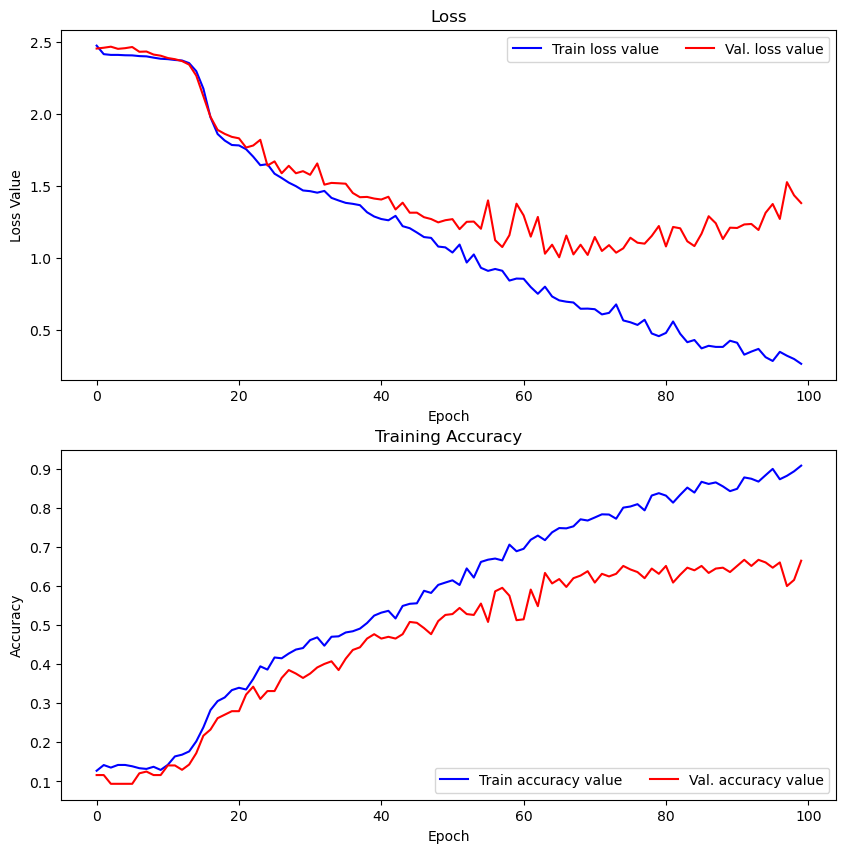

In [9]:
plt.subplot(2,1,1)
plt.plot(loss_train_history, 'b-', label='Train loss value')
plt.plot(loss_val_history, 'r-', label='Val. loss value')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(ncol=2, loc='upper right')

plt.subplot(2,1,2)
plt.plot(acc_train_history, 'b-', label='Train accuracy value')
plt.plot(acc_val_history, 'r-', label='Val. accuracy value')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(10, 10)
plt.show()